In [1]:
%%capture

# Install Dependencies if you haven't already.
!pip install pandas
!pip install scikit-learn
!pip install pmdarima
!clear

# Import Neccessary Libraries
import random
import numpy as np
import pandas as pd
import pmdarima as pm
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE

from keras.models import Sequential
from keras.layers import LSTM, Dense

from statsmodels.tsa.statespace.sarimax import SARIMAX

from IPython.display import clear_output

clear_output(wait=True)

In [2]:
df = pd.read_csv('client-raw-data/csv/sales-history-delhi-5yrs.csv')
df.head()

,Voucher Number,Reference,Date,Voucher Type,Party Name,Party Alias,Buyer's TIN No.,CST Number,Item Name,Godown,...,Alternate Billed Quantity,Rate,Purchase Rate,Unit,Discount,Discount Amount,Margin,Amount,Purchase/Sales Ledger,Narration
0,PFIDEL001/18-19,PFIDEL001/17-18,3-Apr-18,Sales,Prem Enviromantel Solutions,NaN,03262165823,NaN,"20"" BB L -1""",Main Location,...,NaN,420.0,355.0,Nos,0,NaN,942.82,5040.0,IGST Sale,NaN
1,PFIDEL001/18-19,PFIDEL001/17-18,3-Apr-18,Sales,Prem Enviromantel Solutions,NaN,03262165823,NaN,MEMFLO-4-300-2,Main Location,...,NaN,2700.0,2400.0,Nos,0,NaN,1936.11,13500.0,IGST Sale,NaN
2,PFIDEL001/18-19,PFIDEL001/17-18,3-Apr-18,Sales,Prem Enviromantel Solutions,NaN,03262165823,NaN,"SPG 1354-2.5"" T",Main Location,...,NaN,3100.0,2881.0,Nos,0,NaN,1914.87,18600.0,IGST Sale,NaN
3,PFIDEL002/18-19,PFIDEL002/17-18,3-Apr-18,Sales,Jal Jeevan Engineers,NaN,07670425885,NaN,"FRP 3072 - 4""TB",Main Location,...,NaN,24000.0,20663.0,Nos,0,NaN,6674.00,48000.0,SCGST Sale,NaN
4,PFIDEL002/18-19,PFIDEL002/17-18,3-Apr-18,Sales,Jal Jeevan Engineers,NaN,07670425885,NaN,"FRP 3672 - 4""TB",Main Location,...,NaN,32000.0,26330.0,Nos,0,NaN,11340.00,64000.0,SCGST Sale,NaN


In [3]:
# Replace 'column_to_drop_1' and 'column_to_drop_2' with the names of the columns you want to drop
df = df.drop(['Voucher Number', # Just the Invoice Number Sequentially
              'Reference', # Almost All Empty
              'Voucher Type', # All Same (Sales)
              'Party Alias', # All Empty
              "Buyer's TIN No.", # Many Empty, Correlated to 'Party Name'
              'CST Number', # > 80% All Empty
              'Godown', # All Same (Main-Location)
              'Item Batch', # All Same (Primary-Batch)
              'Acutal Quantity', # All Same as 'Billed Qty'
              'Alternate Actual Quantity', # All-Empty
              'Alternate Billed Quantity', # All-Empty
              'Unit', # All-Same (Nos)
              'Discount', # All-Empty
              'Discount Amount', # All-Empty
              'Narration', # All-Empty
             ], axis=1)
df.head()

,Date,Party Name,Item Name,Billed Quantity,Rate,Purchase Rate,Margin,Amount,Purchase/Sales Ledger
0,3-Apr-18,Prem Enviromantel Solutions,"20"" BB L -1""",12.0,420.0,355.0,942.82,5040.0,IGST Sale
1,3-Apr-18,Prem Enviromantel Solutions,MEMFLO-4-300-2,5.0,2700.0,2400.0,1936.11,13500.0,IGST Sale
2,3-Apr-18,Prem Enviromantel Solutions,"SPG 1354-2.5"" T",6.0,3100.0,2881.0,1914.87,18600.0,IGST Sale
3,3-Apr-18,Jal Jeevan Engineers,"FRP 3072 - 4""TB",2.0,24000.0,20663.0,6674.00,48000.0,SCGST Sale
4,3-Apr-18,Jal Jeevan Engineers,"FRP 3672 - 4""TB",2.0,32000.0,26330.0,11340.00,64000.0,SCGST Sale


In [4]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

df.head()

,Party Name,Item Name,Billed Quantity,Rate,Purchase Rate,Margin,Amount,Purchase/Sales Ledger
Date,,,,,,,,
2018-04-03,Prem Enviromantel Solutions,"20"" BB L -1""",12.0,420.0,355.0,942.82,5040.0,IGST Sale
2018-04-03,Prem Enviromantel Solutions,MEMFLO-4-300-2,5.0,2700.0,2400.0,1936.11,13500.0,IGST Sale
2018-04-03,Prem Enviromantel Solutions,"SPG 1354-2.5"" T",6.0,3100.0,2881.0,1914.87,18600.0,IGST Sale
2018-04-03,Jal Jeevan Engineers,"FRP 3072 - 4""TB",2.0,24000.0,20663.0,6674.00,48000.0,SCGST Sale
2018-04-03,Jal Jeevan Engineers,"FRP 3672 - 4""TB",2.0,32000.0,26330.0,11340.00,64000.0,SCGST Sale


In [5]:
# Group the data by month and item, summing the 'Billed Quantity'
monthly_data = df.groupby([pd.Grouper(freq='M'), 'Item Name'])['Billed Quantity'].sum().reset_index()
print(monthly_data)

# Filter the groups based on the condition that the 'Billed Quantity' is at least 25 every month
filtered_data = monthly_data[monthly_data['Billed Quantity'] >= 25]

# Get unique item names in the filtered DataFrame
unique_items = filtered_data['Item Name'].unique()

           Date              Item Name  Billed Quantity
0    2018-04-30          10" Blue L 1"             24.0
1    2018-04-30           20" BB L -1"             46.0
2    2018-04-30          20" BB L 1.5"             30.0
3    2018-04-30          20" Blue L 1"              9.0
4    2018-04-30        20" Blue L 1/2"             20.0
...         ...                    ...              ...
7198 2023-03-31  TSF 4272 6FL T&B - HH              1.0
7199 2023-03-31  TSF 4872 6FL T&B - HH              2.0
7200 2023-03-31           UV -ECS 004L              5.0
7201 2023-03-31                 VC 1.5             10.0
7202 2023-03-31                  VC 2"              8.0

[7203 rows x 3 columns]


# SARIMAX Time-Series Model Implementation
---

In [6]:
def forecast_item_demand(item_name, data, plot, train_size=0.8, min_samples=24):
    # Filter data for the specific item
    item_data = data[data['Item Name'] == item_name].set_index('Date').asfreq('M')

    # Interpolate missing values using the time method
    item_data['Billed Quantity'] = item_data['Billed Quantity'].interpolate(method='time')

    # Ensure that there are enough samples before running the forecasting model
    if len(item_data) < min_samples:
        print(f"Skipping {item_name} due to insufficient data.")
        return None
    
    # Split data into training and testing sets
    train_len = int(len(item_data) * train_size)
    train_data = item_data.iloc[:train_len]
    test_data = item_data.iloc[train_len:]
    
    
    try:
        # Use auto_arima to find the best model parameters
        model = pm.auto_arima(train_data['Billed Quantity'], seasonal=True, m=12, suppress_warnings=True)

        # Forecast inventory demand for the test period
        forecast = model.predict(n_periods=len(test_data))

        # Calculate the Mean Absolute Error (MAE)
        mae = mean_absolute_error(test_data['Billed Quantity'], forecast)

    except ValueError as ve:
        print(f"Skipping {item_name} due to an error: {str(ve)}")
        return None

    if plot:
        # Print the MAE and plot the results
        print(f"Mean Absolute Error for {item_name}: {mae:.2f}")
        plt.figure()
        plt.plot(train_data.index, train_data['Billed Quantity'], label='Train')
        plt.plot(test_data.index, test_data['Billed Quantity'], label='Test')
        plt.plot(test_data.index, forecast, label='Forecast')
        plt.title(f"Inventory Demand Forecast for {item_name}")
        plt.legend()
        plt.show()

    return mae

## Visualization

Mean Absolute Error for SPG 1354-2.5" T: 83.78


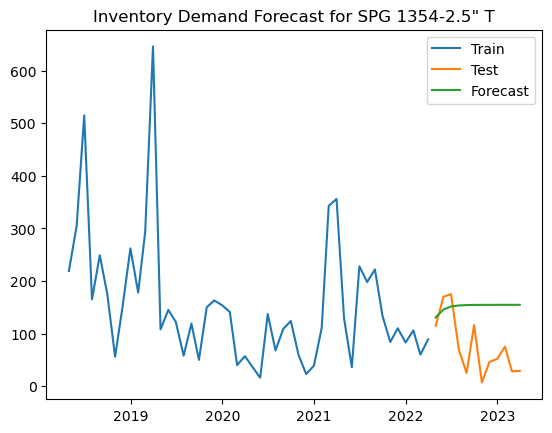

83.77807848602792

In [7]:
# Replace 'item_name' with the name of the item you want to forecast
item_name = "SPG 1354-2.5\" T"
forecast_item_demand(item_name, monthly_data, plot=True)

## Accuracy via. MAE across products

In [8]:
mae_values = []

if len(unique_items) > 0:

    # Apply the forecast_item_demand() function to each unique item
    for item in unique_items:
        mae = forecast_item_demand(item, filtered_data, plot=False)
        if mae is not None:
            mae_values.append(mae)

    # Calculate the mean of all MAEs
    mean_mae = sum(mae_values) / len(mae_values)

    # Clearing the 'Skip' Messages caused from Insufficient Data & ValueErrors
    clear_output(wait=True)
    
    print(f"Mean Absolute Error across all products: {mean_mae:.2f}")
    
else:
    print("No items found with at least 25 units sold every month.")

Mean Absolute Error across all products: 142.51


# LSTM (Long Short-Term Memory) Time Series
---
In this section, we will implement an LSTM (Long Short-Term Memory) model to forecast the demand for each product in our dataset. LSTMs are a type of Recurrent Neural Network (RNN) designed to work with time series data and capture long-range dependencies. They can be especially effective in handling problems that require learning from sequences of data, such as our demand forecasting task.

## Implementation 
Here's a breakdown of the steps we will take:

**Prepare the data**: We will scale the 'Billed Quantity' values using MinMaxScaler, which scales the data to a range between 0 and 1. Scaling helps improve the performance and stability of the LSTM model during training.

**Convert the time series to a supervised learning problem**: To train the LSTM model, we will convert the time series data into a supervised learning format where the input is the demand at a given month, and the output is the demand for the following month.

**Split the data into training and test sets**: We will split the data into a training set (80%) and a test set (20%). The training set will be used to train the model, while the test set will be used to evaluate its performance.

**Build and train the LSTM model**: We will create a simple LSTM model with one LSTM layer containing 50 units and a Dense output layer with one unit. The model will be compiled using the Adam optimizer and Mean Squared Error (MSE) loss function. We will train the model for 300 epochs.

**Evaluate the model**: We will use the Mean Absolute Error (MAE) to evaluate the model's performance on the test set.

In [11]:
def prepare_data_LSTM(data):
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data['Billed Quantity'].values.reshape(-1, 1))
    return data, scaler

def forecast_item_demand_LSTM(item_name, data, min_samples=24, train_size=0.8):
    # Filter the data for the current item
    item_data = data[data['Item Name'] == item_name].set_index('Date').asfreq('M')
    
    # Interpolate missing values using the time method
    item_data['Billed Quantity'] = item_data['Billed Quantity'].interpolate(method='time')

    # Ensure that there are enough samples before running the forecasting model
    if len(item_data) < min_samples:
        print(f"Skipping {item_name} due to insufficient data.")
        return None
    
    # Prepare the data
    data, scaler = prepare_data_LSTM(item_data[['Billed Quantity']])

    # Convert time series to supervised learning problem
    X, y = data[:-1], data[1:]
    X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM

    # Split the data into training and test sets
    train_size = int(len(X) * train_size)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    try:
        # Build the LSTM model
        model = Sequential()
        model.add(LSTM(10, activation='relu', input_shape=(1, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # Train the model
        model.fit(X_train, y_train, epochs=100, verbose=0)

        # Make predictions and evaluate the model
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        print(f"Mean Absolute Error for {item_name}: {mae:.4f}")

        return mae

    except ValueError as ve:
        print(f"Skipping {item_name} due to an error: {str(ve)}")
        return None

# Use the filtered_data DataFrame you prepared earlier
mae_values_LSTM = []

# Apply the forecast_item_demand() function to each unique item
for item in unique_items[:10]:
    mae = forecast_item_demand_LSTM(item, filtered_data)
    if mae is not None:
        mae_values_LSTM.append(mae)

# Calculate the mean of all MAEs
mean_mae = sum(mae_values_LSTM) / len(mae_values_LSTM)

# Clearing the Individual Mean Errors, Skips & Warnings
clear_output(wait=True)

print(f"Mean Absolute Error across all products: {mean_mae:.2f}")

Mean Absolute Error across all products: 0.20


## LSTM Visualisation

Now that we have implemented the LSTM model and evaluated its performance, let's visualize the predicted demand for 3 randomly-selected products in our dataset. By comparing the actual demand with the predicted demand, we can better understand how well our model is performing.

For each of the selected products, we will create a plot showing the actual demand (in blue) and the predicted demand (in orange) for the test set. This will give us an idea of how closely the model's predictions match the true demand.

1/1 [==============================] - 0s 90ms/step
Mean Absolute Error for S-STRAP 4": 0.1269
1/1 [==============================] - 0s 379ms/step


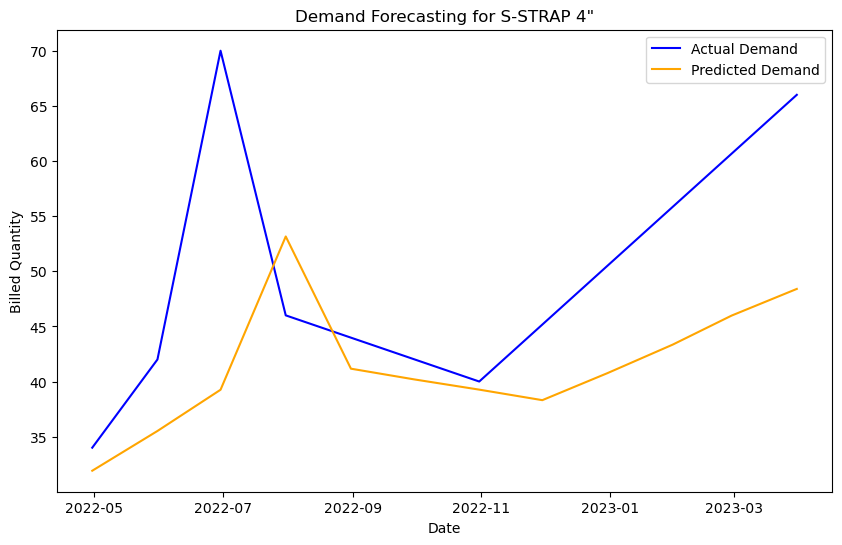

In [12]:
def visualize_random_product(data, unique_items):
    # Select a random product from the list of unique items
    random_item = random.choice(unique_items)
    
    # Get the model and scaler for the selected product
    mae = forecast_item_demand_LSTM(random_item, data)
    if mae is None:
        print("Unable to visualize the selected product.")
        return
    
    # Filter the data for the selected product
    item_data = data[data['Item Name'] == random_item].set_index('Date').asfreq('M')
    
    # Interpolate missing values using the time method
    item_data['Billed Quantity'] = item_data['Billed Quantity'].interpolate(method='time')
    
    # Prepare the data
    data, scaler = prepare_data_LSTM(item_data[['Billed Quantity']])
    
    # Convert time series to supervised learning problem
    X, y = data[:-1], data[1:]
    X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM
    
    # Split the data into training and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # Train the model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=300, verbose=0)
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Inverse transform the scaled data
    y_test = scaler.inverse_transform(y_test)
    predictions = scaler.inverse_transform(predictions)
    
    # Plot the actual demand and predicted demand
    plt.figure(figsize=(10, 6))
    plt.plot(item_data.index[train_size+1:], y_test, label='Actual Demand', color='blue')
    plt.plot(item_data.index[train_size+1:], predictions, label='Predicted Demand', color='orange')
    plt.title(f"Demand Forecasting for {random_item}")
    plt.xlabel('Date')
    plt.ylabel('Billed Quantity')
    plt.legend()
    plt.show()

# Visualize a random product
visualize_random_product(filtered_data, unique_items)